<br>

## 데이터 불러오기

<br>

In [3]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
!mv ratings_*.txt ~/aiffel/sentiment_classification


--2021-01-14 16:23:39--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.108.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt.1’

ratings_train.txt.1 100%[===================>]  13.95M  1.96MB/s    in 6.4s    

2021-01-14 16:23:46 (2.19 MB/s) - ‘ratings_train.txt.1’ saved [14628807/14628807]

--2021-01-14 16:23:46--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.108.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt.1’

ratings_test.txt.1  100%[===================>]

In [131]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

print("훈련 샘플 개수: {}".format(len(train_data)))
print("테스트 개수: {}".format(len(test_data)))
train_data.head()

훈련 샘플 개수: 150000
테스트 개수: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


<br>

## 데이터 전처리 : word to index <br>

사전을 만들기 위한 준비

<br>

In [133]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [134]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [135]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

<br>

## 데이터 전처리 : padding <br>

- padding을 통해 생성한 문장의 길이도 모델 성능에 영향을 미침
- padding 방식 : 뒷쪽post과 앞쪽pre 중 어느쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생 <br>
( 두 가지 방식을 한번씩 다 적용해서 RNN을 학습시켜 보면서 그 결과를 비교 )

<br>

In [136]:
"""
문장 최대 길이 (데이터 길이)도 설정도 전체 모델 성능에 영향을 미치므로 적절한 max값 선정
"""

total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [137]:
"""
keras.preprocessing.sequence.pad_sequences() 메소드로 패딩을 통해 데이터 길이 맞추기
"""

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


<br>

## 모델 1 생성 : 1-D CNN (1-D Convolution Neural Network)

<br>

In [138]:
"""
1-D CNN 모델 구성
"""

vocab_size = 10000  # 어휘 사전의 크기 (10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수

model_1 = keras.Sequential()
model_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_1.add(keras.layers.MaxPooling1D(5))
model_1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_1.add(keras.layers.GlobalMaxPooling1D())
model_1.add(keras.layers.Dense(8, activation='relu'))
model_1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 16)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_35 (Dense)             (None, 1)               

<br>

### 모델 1 train set / validation set 분리

<br>

In [139]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


<br>

### 모델 1 compile 및 학습

<br>

In [140]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

model_1_history = model_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 1s 6ms/step - loss: 0.4882 - accuracy: 0.7568 - val_loss: 0.3489 - val_accuracy: 0.8448
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3261 - accuracy: 0.8609 - val_loss: 0.3332 - val_accuracy: 0.8521
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2963 - accuracy: 0.8767 - val_loss: 0.3460 - val_accuracy: 0.8497
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2722 - accuracy: 0.8881 - val_loss: 0.3309 - val_accuracy: 0.8580
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2448 - accuracy: 0.9028 - val_loss: 0.3414 - val_accuracy: 0.8570
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2150 - accuracy: 0.9177 - val_loss: 0.3579 - val_accuracy: 0.8533
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1846 - accuracy: 0.9328 - val_loss: 0.3872 - val_accuracy: 0.8486
Epoch 

<br>

### 모델 1 평가

<br>

In [141]:
# 학습이 끝난 모델을 테스트셋으로 평가

results = model_1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.9210 - accuracy: 0.8201
[0.9209529757499695, 0.8200663328170776]


In [142]:
"""
model.fit().history 통해 모델평가지표 읽어오기
"""

model_1_history_dict = model_1_history.history
print(model_1_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


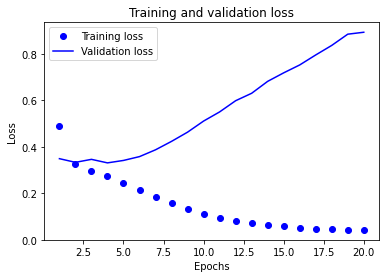

In [143]:
"""
matplotlib 으로 모델평가지표 시각화 : loss
"""

import matplotlib.pyplot as plt

acc = model_1_history_dict['accuracy']
val_acc = model_1_history_dict['val_accuracy']
loss = model_1_history_dict['loss']
val_loss = model_1_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo : 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b : 파란 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

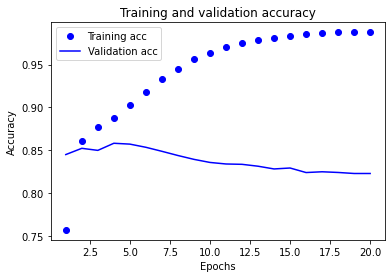

In [144]:
"""
matplotlib 으로 모델평가치표 시각화 : accuracy
"""

plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

<br>

### 모델 1 종합평가 <br>

__오버피팅__ <br><br>

학습데이터에 대해서만 학습이 잘 일어나고 검증데이터에 대해서는 학습이 저조합니다. <br>
학습셋과의 loss 및 acc 격차가 점점 커지며 엄청난 오버피팅이 일어난 것을 알 수 있습니다. <br>
검증셋에 대한 acc는 점점 떨어지는 모습을 보입니다.

<br>

<br>

## 모델 2 생성 : Embbeded 1-D CNN (1-D Convolution Neural Network) <br>
### Google의 word2vec pre-trained 모델을 Embbeding layer로 추가

<br>

In [145]:
"""
구글의 워드벡터 모델 GoogleNews-vectors-negative300.bin.gz 읽어오기
"""

from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)

# 'computer'에 대응하는 워드벡터 확인
"""
vector = word2vec['computer']
vector     # 300dim의 워드 벡터
"""

"\nvector = word2vec['computer']\nvector     # 300dim의 워드 벡터\n"

In [146]:
"""
embedding matrix 생성
"""

vocab_size = 10000    # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# pre-trained 워드벡터의 크기에 맞는 matrix 생성
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [147]:
"""
1-D CNN 모델에 Google 워드벡터 모델을 Embedding layer에 추가하여 모델 구성
"""

from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model_2 = keras.Sequential()
model_2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(keras.layers.MaxPooling1D(5))
model_2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(keras.layers.GlobalMaxPooling1D())
model_2.add(keras.layers.Dense(8, activation='relu'))
model_2.add(keras.layers.Dense(1, activation='sigmoid')) 

model_2.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 7, 16)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 16)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_37 (Dense)             (None, 1)               

<br>

### 모델 2 train set / validation set 분리

<br>

In [148]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


<br>

### 모델 2 compile 및 학습

<br>

In [149]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

model_2_history = model_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 9s 35ms/step - loss: 0.6205 - accuracy: 0.6221 - val_loss: 0.4163 - val_accuracy: 0.8110
Epoch 2/20
266/266 [==============================] - 9s 35ms/step - loss: 0.3731 - accuracy: 0.8358 - val_loss: 0.3488 - val_accuracy: 0.8496
Epoch 3/20
266/266 [==============================] - 9s 35ms/step - loss: 0.3223 - accuracy: 0.8636 - val_loss: 0.3388 - val_accuracy: 0.8510
Epoch 4/20
266/266 [==============================] - 9s 35ms/step - loss: 0.2898 - accuracy: 0.8801 - val_loss: 0.3534 - val_accuracy: 0.8499
Epoch 5/20
266/266 [==============================] - 9s 35ms/step - loss: 0.2659 - accuracy: 0.8918 - val_loss: 0.3455 - val_accuracy: 0.8495
Epoch 6/20
266/266 [==============================] - 9s 35ms/step - loss: 0.2424 - accuracy: 0.9032 - val_loss: 0.3584 - val_accuracy: 0.8484
Epoch 7/20
266/266 [==============================] - 10s 36ms/step - loss: 0.2158 - accuracy: 0.9165 - val_loss: 0.3768 - val_accuracy: 0.847

<br>

### 모델 2 평가

<br>

In [150]:
# 학습이 끝난 모델을 테스트셋으로 평가

results = model_2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7863 - accuracy: 0.8116
[0.7862532734870911, 0.8115629553794861]


In [151]:
"""
model.fit().history 통해 모델평가지표 읽어오기
"""

model_2_history_dict = model_2_history.history
print(model_2_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


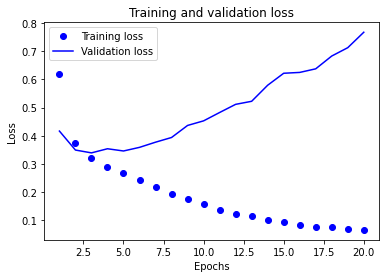

In [152]:
"""
matplotlib 으로 모델평가지표 시각화 : loss
"""

import matplotlib.pyplot as plt

acc = model_2_history_dict['accuracy']
val_acc = model_2_history_dict['val_accuracy']
loss = model_2_history_dict['loss']
val_loss = model_2_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo : 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b : 파란 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

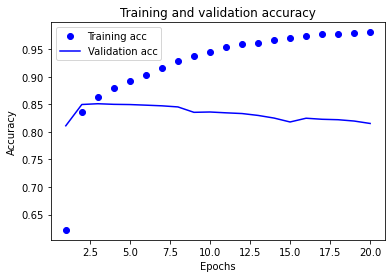

In [153]:
"""
matplotlib 으로 모델평가치표 시각화 : accuracy
"""

plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

<br>

### 모델 2 종합평가 <br>

__오버피팅__ <br><br>

학습데이터에 대해서만 학습이 잘 일어나고 검증데이터에 대해서는 학습이 저조합니다. <br>
학습셋과의 loss 및 acc 격차가 점점 커지며 엄청난 오버피팅이 일어난 것을 알 수 있습니다. <br>
검증셋에 대한 acc는 점점 떨어지는 모습을 보입니다. <br><br>

두 모델 모두 1-D CNN을 사용해서 그런지 전체적으로 모델1과 거의 흡사합니다. <br>
모델1 보다 약간 높은 accucy를 보였습니다.


<br>

<br>

## 모델 3 생성 : Embbeded RNN LSTM <br>
### 한글 word2vec pre-trained 모델을 Embbeding layer로 추가

<br>

In [69]:
"""
한글 워드벡터 모델 ko.bin 읽어오기
"""

import gensim

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

"""
# '사랑'에 대응하는 워드벡터 확인
vector = word2vec['사랑']
vector     # 200dim의 워드 벡터
"""

"\n# '사랑'에 대응하는 워드벡터 확인\nvector = word2vec['사랑']\nvector     # 300dim의 워드 벡터\n"

In [71]:
"""
embedding matrix 생성
"""

vocab_size = 10000    # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# pre-trained 워드벡터의 크기에 맞는 matrix 생성
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [124]:
"""
RNN 모델에 한글 워드벡터 모델을 Embedding layer에 추가하여 모델 구성
"""

from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model_3 = keras.Sequential()
model_3.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_3.add(keras.layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_3.add(keras.layers.SpatialDropout1D(0.2))
model_3.add(keras.layers.MaxPooling1D(5))
model_3.add(keras.layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_3.add(keras.layers.SpatialDropout1D(0.2))
model_3.add(keras.layers.GlobalMaxPooling1D())
model_3.add(keras.layers.Dense(8, activation='relu'))
model_3.add(keras.layers.Dense(1, activation='sigmoid')) 

model_3.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_24 (LSTM)               (None, 41, 32)            29824     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 41, 32)            0         
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 8, 32)             8320      
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 8, 32)             0         
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 32)              

<br>

### 모델 3 train set / validation set 분리

<br>

In [125]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


<br>

### 모델 2 compile 및 학습

<br>

In [126]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

model_3_history = model_3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 36s 135ms/step - loss: 0.5935 - accuracy: 0.6591 - val_loss: 0.4358 - val_accuracy: 0.7996
Epoch 2/20
266/266 [==============================] - 35s 132ms/step - loss: 0.4239 - accuracy: 0.8080 - val_loss: 0.3683 - val_accuracy: 0.8354
Epoch 3/20
266/266 [==============================] - 34s 130ms/step - loss: 0.3763 - accuracy: 0.8337 - val_loss: 0.3496 - val_accuracy: 0.8442
Epoch 4/20
266/266 [==============================] - 34s 130ms/step - loss: 0.3526 - accuracy: 0.8445 - val_loss: 0.3425 - val_accuracy: 0.8485
Epoch 5/20
266/266 [==============================] - 35s 131ms/step - loss: 0.3374 - accuracy: 0.8544 - val_loss: 0.3391 - val_accuracy: 0.8503
Epoch 6/20
266/266 [==============================] - 35s 130ms/step - loss: 0.3272 - accuracy: 0.8597 - val_loss: 0.3358 - val_accuracy: 0.8530
Epoch 7/20
266/266 [==============================] - 34s 130ms/step - loss: 0.3177 - accuracy: 0.8642 - val_loss: 0.3382 - val_ac

<br>

### 모델 3 평가

<br>

In [127]:
# 학습이 끝난 모델을 테스트셋으로 평가

results = model_3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 18s - loss: 0.3608 - accuracy: 0.8533
[0.36079663038253784, 0.8533270955085754]


In [128]:
"""
model.fit().history 통해 모델평가지표 읽어오기
"""

model_3_history_dict = model_3_history.history
print(model_3_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


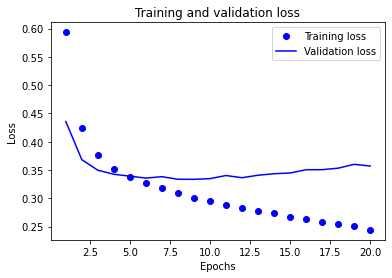

In [129]:
"""
matplotlib 으로 모델평가지표 시각화 : loss
"""

import matplotlib.pyplot as plt

acc = model_3_history_dict['accuracy']
val_acc = model_3_history_dict['val_accuracy']
loss = model_3_history_dict['loss']
val_loss = model_3_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo : 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b : 파란 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

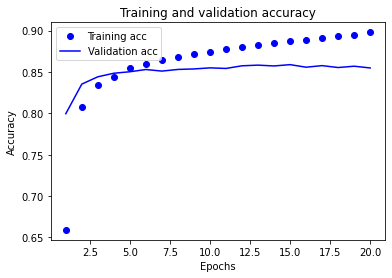

In [130]:
"""
matplotlib 으로 모델평가치표 시각화 : accuracy
"""

plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

<br>

### 모델 3 종합평가 <br>

일정 에포크(5) 이상의 학습부터는 acc 향상이 거의 없었고, loss는 증가하는 약간의 과적합을 보였습니다.
하지만 학습 초반의 학습률을 데이터셋과 검증셋이 함께 증가하는 모습을 보이며 최종 결과에서 좋은 모습을 보였습니다.

<br>

<br>

### 성능향상을 위한 모델 구성들

- LSTM 레이어를 여러개 쌓아도 성능 향상이 크진 않았습니다.
- LSTM 레이어 두개에 맥스풀링까지 더하였는데 acc=0.81 정도까지 올라가는 성능 향상을 보였습니다.
- 드랍아웃이 좋다고 하여 LSTM 두개에 드랍아웃에 맥스풀링까지 쌓아서 acc=0.85 까지 향상을 보였습니다.

<br>